In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.special import legendre, chebyt

from src.sindy_utils import library_size

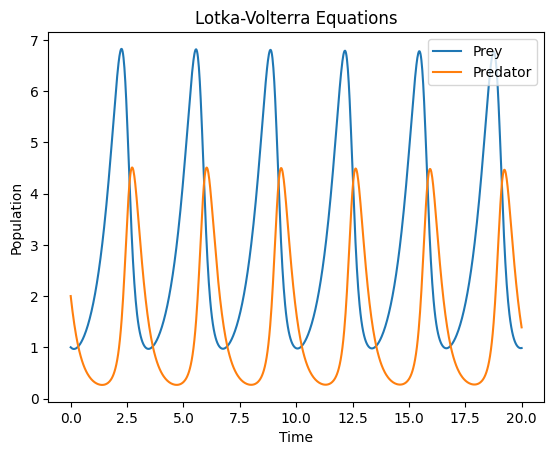

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the Lotka-Volterra equations
def lotka_volterra(t, y, a, b, c, d):
    u, v = y
    du = a*u - b*u*v
    dv = -c*v + d*u*v
    return [du, dv]

# u = population of the prey
# v = popolation of the predator

# Set the parameter values and initial conditions
a = 1.5         # birth rate of the prey
b = 1           # death rate of the prey due to predation
c = 3           # death rate of the predator in the absence of prey
d = 1           # conversion efficiency of the predator
y0 = [1, 2]

# Set the time range for simulation
t_start = 0
t_end = 20
t_eval = np.linspace(t_start, t_end, 1000)

# Solve the differential equations using solve_ivp
sol = solve_ivp(lotka_volterra, [t_start, t_end], y0, t_eval=t_eval, args=(a, b, c, d), method='LSODA')
# or method = RK45  which is the default one

# Plot the results
plt.plot(sol.t, sol.y[0], label='Prey')
plt.plot(sol.t, sol.y[1], label='Predator')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Lotka-Volterra Equations')
plt.legend()
plt.show()


In [19]:
def get_lofka_volterra_data(n_ics, noise_strength=0):
    """
    Generate a set of Lofka-Volterra training data for multiple random initial conditions.

    Arguments:
        n_ics - Integer specifying the number of initial conditions to use.
        noise_strength - Amount of noise to add to the data.

    Return:
        data - Dictionary containing elements of the dataset. See generate_lofka_volterra_data()
        doc string for list of contents.
    """
    t = np.arange(0, 20, .02)
    n_steps = t.size
    input_dim = 128 # chosen dimension for the high-dimensional dataset x(t)

    ic_means = np.array([4,2.5])  # mean values for the possible initial conditions of the variables
    ic_widths = 2*np.array([5,4]) # extent of the values in the trajectories

    # training data
    ics = ic_widths*(np.random.rand(n_ics, 2)-.5) + ic_means  # inital conditions (n_ics x 2 variables)
    data = generate_lofka_volterra_data(ics, t, input_dim, linear=False, normalization=np.array([1/10,1/10]), a = 1.5, b=1., c=3.,d=1.)
    # I set the scaling parameters as equal to each other since both variable represent population, but i don't really know how to choose the value exactly
    data['x'] = data['x'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['dx'] = data['dx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)
    data['ddx'] = data['ddx'].reshape((-1,input_dim)) + noise_strength*np.random.randn(n_steps*n_ics,input_dim)

    return data

In [15]:
X = np.zeros((library_size(2,2),2))
    #            du       dv
    #      1  [     0,         0] 0
    #      u  [     a,         0] 1
    #      v  [     0,        -c] 2
    #      u^2 [     0,         0] 3
    #      uv [    -b,         d] 4
    #      v^2 [     0,         0] 5
X

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [20]:
def lofka_volterra_coefficients(normalization, poly_order=2, a=1.5, b=1., c=3., d=1.):
    """
    Generate the SINDy coefficient matrix

    Arguments:
        normalization - 2-element list of array specifying scaling of each variable of the system
        poly_order - Polynomial order of the SINDy model.
        a, b, c, d - Parameters of the Lorenz system
    """
    Xi = np.zeros((library_size(2,poly_order),2))
    Xi[1,0] = a
    Xi[4,0] = -b*normalization[0]/normalization[1]
    Xi[2,1] = -c
    Xi[4,1] = d*normalization[1]/normalization[0]
    return Xi

In [21]:
def simulate_lofka_volterra(z0, t, a=1.5, b=1., c=3., d=1.):
    """
    Simulate the Lofka-Volterra equations dynamics.

    Arguments:
        z0 - Initial condition in the form of a 3-value list or array.
        t - Array of time points at which to simulate.
        a, b, c, d - parameters

    Returns:
        z, dz, ddz - Arrays of the trajectory values and their 1st and 2nd derivatives.
    """
    f = lambda z,t : [a*z[0] - b*z[0]*z[1], -c*z[1] + d*z[0]*z[1]]
    df = lambda z,dz,t : [a*dz[0] - b*(dz[0]*z[1] + z[0]*dz[1]), -c*dz[1] + d*(dz[0]*z[1]+z[0]*dz[1])]

    z = odeint(f, z0, t)

    dt = t[1] - t[0]
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(t.size):
        dz[i] = f(z[i],dt*i)
        ddz[i] = df(z[i], dz[i], dt*i)
    return z, dz, ddz


In [22]:
def generate_lofka_volterra_data(ics, t, n_points, linear=True, normalization=None,
                            a=1.5, b=1., c=3., d=1.):
    """
    Generate high-dimensional Lofka-Volterra data set. (starting from the values of the actual dataset from Lofka-Volterra system)

    Arguments:
        ics - Nx2 array of N initial conditions (e.g. z0)
        t - array of time points over which to simulate
        n_points - size of the high-dimensional dataset created --> it's equal to input_dim when we use it in get_lofka_volterra_data
        linear - Boolean value. If True, high-dimensional dataset is a linear combination
        of the Lofka-Volterra dynamics. If False, the dataset also includes cubic modes.
        normalization - Optional 2-value array for rescaling the 2 Lofka-Volterra variables.
        a, b, c, d - Parameters of the ynamical system

    Returns:
        data - Dictionary containing elements of the dataset. This includes the time points (t),
        spatial mapping (y_spatial), high-dimensional modes used to generate the full dataset
        (modes), low-dimensional Lofka-Volterra dynamics (z, along with 1st and 2nd derivatives dz and
        ddz), high-dimensional dataset (x, along with 1st and 2nd derivatives dx and ddx), and
        the true Lofka-Volterra coefficient matrix for SINDy.
    """

    n_ics = ics.shape[0]
    n_steps = t.size
    dt = t[1]-t[0]

    # dd = dimension of the latent space z
    dd = 2  # had to change from d to dd in this example since there is the cooefficient of the system called d
    z = np.zeros((n_ics,n_steps,dd))
    dz = np.zeros(z.shape)
    ddz = np.zeros(z.shape)
    for i in range(n_ics):
        # simulate actual values of the LV variables for each initial condition
        z[i], dz[i], ddz[i] = simulate_lofka_volterra(ics[i], t, a=a, b=b, c=c, d=d)

    # normalize the obtained values
    if normalization is not None:
        z *= normalization
        dz *= normalization
        ddz *= normalization

    # create the modes for the latent subspace
    n = n_points  # dimension of x(t) at a given time t
    L = 1
    y_spatial = np.linspace(-L,L,n)

    modes = np.zeros((2*dd, n))   # 2 because we keep 2 terms in the polynomial: z and z^3
    for i in range(2*dd):
        modes[i] = legendre(i)(y_spatial)
        # modes[i] = chebyt(i)(y_spatial)
        # modes[i] = np.cos((i+1)*np.pi*y_spatial/2)
    x1 = np.zeros((n_ics,n_steps,n))
    x2 = np.zeros((n_ics,n_steps,n))
    x3 = np.zeros((n_ics,n_steps,n))
    x4 = np.zeros((n_ics,n_steps,n))

    x = np.zeros((n_ics,n_steps,n))
    dx = np.zeros(x.shape)
    ddx = np.zeros(x.shape)
    for i in range(n_ics):
        for j in range(n_steps):
            x1[i,j] = modes[0]*z[i,j,0]
            x2[i,j] = modes[1]*z[i,j,1]
            x3[i,j] = modes[2]*z[i,j,0]**3
            x4[i,j] = modes[3]*z[i,j,1]**3

            x[i,j] = x1[i,j] + x2[i,j]
            if not linear:
                x[i,j] += x3[i,j] + x4[i,j]

            dx[i,j] = modes[0]*dz[i,j,0] + modes[1]*dz[i,j,1]
            if not linear:
                dx[i,j] += modes[2]*3*(z[i,j,0]**2)*dz[i,j,0] + modes[3]*3*(z[i,j,1]**2)*dz[i,j,1]

            ddx[i,j] = modes[0]*ddz[i,j,0] + modes[1]*ddz[i,j,1]
            if not linear:
                ddx[i,j] += modes[2]*(6*z[i,j,0]*dz[i,j,0]**2 + 3*(z[i,j,0]**2)*ddz[i,j,0]) \
                          + modes[3]*(6*z[i,j,1]*dz[i,j,1]**2 + 3*(z[i,j,1]**2)*ddz[i,j,1])

    if normalization is None:
        sindy_coefficients = lofka_volterra_coefficients([1,1,1], a=a, b=b, c=c, d=d)
    else:
        sindy_coefficients = lofka_volterra_coefficients(normalization, a=a, b=b, c=c, d=d)

    data = {}
    data['t'] = t
    data['y_spatial'] = y_spatial
    data['modes'] = modes
    data['x'] = x
    data['dx'] = dx
    data['ddx'] = ddx
    data['z'] = z
    data['dz'] = dz
    data['ddz'] = ddz
    data['sindy_coefficients'] = sindy_coefficients.astype(np.float32)

    return data
